In [1]:
!pip install fastprogress

In [2]:
import csv
import torch
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import pandas as pd

import torch.nn as nn
import torch.optim as optim

import numpy as np
import h5py

from fastprogress import master_bar, progress_bar

In [3]:
# Custom char tokenizer
def char_tokenizer(text):
    return list(text)

# Yield tokens from dataset for vocabulary building
def yield_tokens(data):
    for src, trg in data:
        yield char_tokenizer(src)
        yield char_tokenizer(trg)

# Load data from CSV
def load_data_from_csv(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        data = [(row[0], row[1]) for row in csv_reader]
    return data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_data_raw = load_data_from_csv('/content/drive/MyDrive/Colab/password_predict/data/train_100_1m.csv')
val_data_raw = load_data_from_csv('/content/drive/MyDrive/Colab/password_predict/data/val_100_50k.csv')
test_data_raw = load_data_from_csv('/content/drive/MyDrive/Colab/password_predict/data/test_100_50k.csv')

In [6]:
vocab = build_vocab_from_iterator(yield_tokens(train_data_raw), specials=['<sos>', '<eos>', '<unk>'])
vocab.set_default_index(vocab["<unk>"])

print(f"Vocab length: {len(vocab)}")

Vocab length: 98


In [7]:
# save vocab
import pickle

with open('/content/drive/MyDrive/Colab/password_predict/data/vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [8]:
# Dataset class
class CSVDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        src, trg = self.data[index]
        src = [self.vocab[token] for token in char_tokenizer(src)]
        trg = [self.vocab['<sos>']] + [self.vocab[token] for token in char_tokenizer(trg)]  # prepend <sos>
        return torch.tensor(src), torch.tensor(trg)

In [9]:
# Padding function
def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=vocab['<eos>'], batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=vocab['<eos>'], batch_first=True)
    return src_batch, trg_batch

In [10]:
# DataLoader
BATCH_SIZE = 128

train_dataset = CSVDataset(train_data_raw, vocab)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

val_dataset = CSVDataset(val_data_raw, vocab)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)  # Usually, no need to shuffle val/test data

test_dataset = CSVDataset(test_data_raw, vocab)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

In [11]:
# check sample from dataset
for src, trg in train_dataset:
    print(src, trg)
    break

tensor([20, 11,  4,  6,  7,  3, 13,  4]) tensor([ 0, 29,  3, 11, 11])


In [12]:
# Sample usage:
for src, trg in train_loader:
    # src and trg here are tokenized, batched, and padded sequences
    print(src.shape, trg.shape)
    break

torch.Size([128, 20]) torch.Size([128, 21])


In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[0, :]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = torch.rand(1) < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

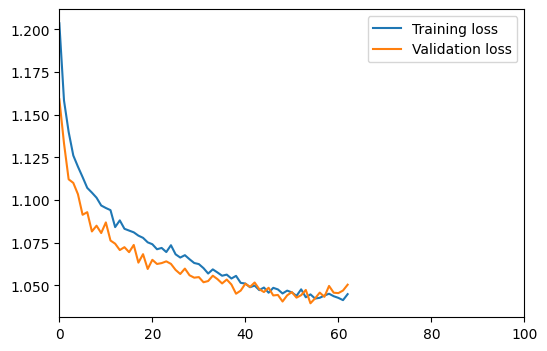

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


Validation loss decreased (inf --> 1.159051).  Saving model ...


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Validation loss decreased (1.159051 --> 1.133265).  Saving model ...
Validation loss decreased (1.133265 --> 1.112159).  Saving model ...
Validation loss decreased (1.112159 --> 1.110047).  Saving model ...
Validation loss decreased (1.110047 --> 1.103408).  Saving model ...
Validation loss decreased (1.103408 --> 1.091354).  Saving model ...
Validation loss decreased (1.091354 --> 1.081598).  Saving model ...
Validation loss decreased (1.081598 --> 1.080662).  Saving model ...
Validation loss decreased (1.080662 --> 1.076267).  Saving model ...
Validation loss decreased (1.076267 --> 1.074424).  Saving model ...
Validation loss decreased (1.074424 --> 1.070697).  Saving model ...
Validation loss decreased (1.070697 --> 1.069435).  Saving model ...
Validation loss decreased (1.069435 --> 1.063316).  Saving model ...
Validation loss decreased (1.063316 --> 1.059604).  Saving model ...
Validation loss decreased (1.059604 --> 1.059047).  Saving model ...
Validation loss decreased (1.05904

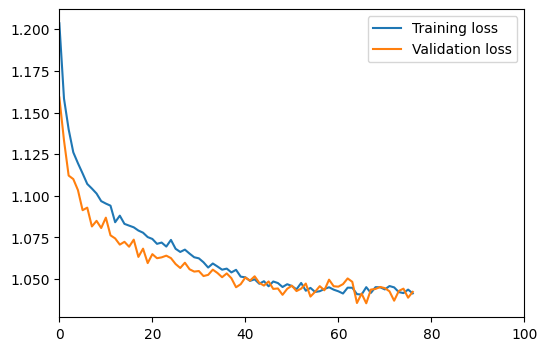

Validation loss decreased (1.039497 --> 1.035636).  Saving model ...
Validation loss decreased (1.035636 --> 1.035473).  Saving model ...


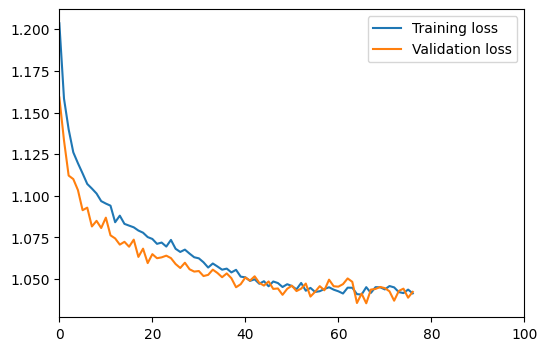

In [ ]:
# Assuming src and trg are your tokenized, padded source and target sequences
INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(enc, dec, device).to(device)

lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-5)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=10)

epochs=100

mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

# Training loop
for epoch in mb:
  x.append(epoch)
  total_loss = torch.Tensor([0.0]).to(device)

  # train
  model.train()
  for batch in progress_bar(train_loader, parent=mb):
      src, trg = batch
      src = src.permute(1, 0).to(device).long()
      trg = trg.permute(1, 0).to(device).long()
      optimizer.zero_grad()
      output = model(src, trg)
      output_dim = output.shape[-1]
      output = output[1:].reshape(-1, output_dim)
      trg = trg[1:].reshape(-1)
      loss = criterion(output, trg)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

  # decay lr
  scheduler.step()
  mean = total_loss / len(train_loader)
  training_losses.append(mean.cpu())

  # validation
  model.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_loader, parent=mb):
      src, trg = batch
      src = src.permute(1, 0).to(device).long()
      trg = trg.permute(1, 0).to(device).long()
      output = model(src, trg)
      output_dim = output.shape[-1]
      output = output[1:].reshape(-1, output_dim)
      trg = trg[1:].reshape(-1)
      loss = criterion(output, trg)
      validation_loss += loss.item()

  val_mean = validation_loss / len(val_loader)
  validation_losses.append(val_mean.cpu())
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")

  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/password_predict/pass_predict_100_direct_mapping.pt')
      valid_mean_min = val_mean.item()

  if early_stopper.early_stop(val_mean.item()):
    break

In [17]:
INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(enc, dec, device).to(device)

In [18]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/password_predict/pass_predict_100_direct_mapping.pt'))

<All keys matched successfully>

In [19]:
itos = vocab.get_itos()

In [20]:
itos[0]

'<sos>'

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

model.eval()
total_bleu = 0

with torch.no_grad():
    for src, trg in test_loader:
        src = src.permute(1, 0).to(device).long()
        trg = trg.permute(1, 0).to(device).long()

        # Turn off teacher forcing
        output = model(src, trg, 0)
        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)

        # Convert model's outputs to tokens
        predicted_tokens = torch.argmax(output, dim=1)
        predicted_sentence = [itos[tok.item()] for tok in predicted_tokens]

        reference = [itos[tok.item()] for tok in trg[1:].reshape(-1)]
        total_bleu += sentence_bleu([reference], predicted_sentence)

average_bleu = total_bleu / len(test_loader)
print(f'Average BLEU score: {average_bleu:.3f}')

Average BLEU score: 0.724


In [21]:
def predict(model, vocab, device, src_sentence, n=1):
    model.eval()
    max_seq = 20

    # Convert the source sentence to tokens
    src_tokens = [tok for tok in src_sentence]
    src_indexes = [vocab[tok] for tok in src_tokens] + [vocab['<eos>']]

    # Convert to tensor and add batch dimension
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # Initialize target sequence with <sos> token
    result = []
    for i in range(n):
        trg_indexes = [vocab['<sos>']]
        predicted_sentence = []
        count = 0
        # Predict next token
        while True:
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1).to(device)
            with torch.no_grad():
                output = model(src_tensor, trg_tensor)
                #print(output)
                predicted_token = output.argmax(2)[-1, :].item()
                # Check for end of sentence
                if predicted_token == vocab['<eos>']:
                    break

                # Append the predicted token to the target sequence
                trg_indexes.append(predicted_token)
                # Convert the target sequence to words
                predicted_sentence.append(itos[predicted_token])
                count += 1
                if count > max_seq:
                    break

        # Convert the target sequence to words
        if ''.join(predicted_sentence[1:]) in result:
            continue
        result.append(''.join(predicted_sentence[1:]))

    return result  # Exclude the <sos> token

In [ ]:
!head -10 /content/drive/MyDrive/Colab/password_predict/data/test_100_50k.csv

username,pass
nadina,fuckit
info,giordano
adambale1981,RASPUTINasd
mikamalosh,134679852
buh2,17051960
andri4y,Danara
andrea,junglejim22
oleg272726,zabludshaya
mak38er,pimp4life


In [22]:
predict(model, vocab, device, "admin", 100)

['1a34d566',
 '123346',
 '121313',
 '122313',
 '1a1420',
 '121d4a',
 '121325',
 '1a14a5',
 '1a31a5',
 '1a1nd3',
 '1a3n2i',
 '1a1n2e6',
 '1a32253',
 '122335',
 '1a2243',
 '12n343',
 '1a3d13',
 '1224332',
 '1a3241',
 '1233e54',
 '1233233',
 '122d31',
 '122345',
 '123345',
 '123333',
 '1a3243',
 '122333',
 '1213456',
 '121323',
 '1a2n43',
 '121415',
 '1a3na1',
 '121d2a',
 '1a1d5a',
 '123425',
 '1a31a1',
 '122d46',
 '1annde',
 '1a1415',
 '123343',
 '123d2e',
 '1a2d1a2',
 '1a3n2e3r',
 '1a2203',
 '1a3n23',
 '1a13a3',
 '12n3dea',
 '1a3d43',
 '1233e2',
 '121413',
 '12n33t',
 '123325',
 '1a3n253',
 '1a3de3',
 '1a3nea',
 '1233e3',
 '1an1de',
 '1a1213',
 '121d11',
 '1a14a3',
 '1a2433',
 '1a3nd3a',
 '1a3na669',
 '122343',
 '1anneia',
 '1an1d2',
 '1a1d1a',
 '12n3er',
 '1a2n0i0',
 '1anddea',
 '121315',
 '1a12d3',
 '1an1a2',
 '12234r6',
 '122430',
 '122445',
 '122433',
 '1a11a1',
 '1a23ca',
 '121445',
 '1223336',
 '1ann4e',
 '1214456',
 '121316',
 '12n333',
 '122132',
 '1a13d3',
 '1a3d41',
 '1a1443',

In [23]:
!pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 19.1 MB/s eta 0:00:00


In [24]:
from Levenshtein import distance as lev
lev("123456", "123456")

0

In [25]:
lev("51234", "123456")

3

In [26]:
df = pd.read_csv("/content/drive/MyDrive/Colab/password_predict/data/test_100_50k.csv")
df.head()

,username,pass
0,nadina,fuckit
1,info,giordano
2,adambale1981,RASPUTINasd
3,mikamalosh,134679852
4,buh2,17051960


In [27]:
from tqdm.notebook import tqdm
import pandas as pd
# Assuming the predict and lev functions are defined elsewhere

tqdm.pandas()

def avg_and_min_edit_dist(username, actual_pass):
    pred_passes = predict(model, vocab, device, username, 100)
    if not pred_passes:
        return (0, None)  # Return 0 and None if pred_passes is empty

    # Calculate edit distances between actual_pass and each predicted pass
    edit_distances = [lev(actual_pass, pred_pass) for pred_pass in pred_passes]
    avg_edit_dist = sum(edit_distances) / len(pred_passes)
    best_pred_pass = pred_passes[edit_distances.index(min(edit_distances))]
    return (best_pred_pass, avg_edit_dist)

# Sample a subset of the dataframe
temp_df = df.sample(n=10000)

# Apply the function and create two new columns for best predicted password and average edit distance
temp_df[['best_pred_pass', 'avg_edit_dist']] = temp_df.progress_apply(lambda x: pd.Series(avg_and_min_edit_dist(x['username'], x['pass'])), axis=1)

temp_df.sort_values('avg_edit_dist').head(10)

  0%|          | 0/10000 [00:00<?, ?it/s]

,username,pass,best_pred_pass,avg_edit_dist
25337,chyisn59,chyisn,chyisn,1.500000
20666,kaban2,kaban,kaban,1.571429
47179,fahri,fahri,fahri,2.075000
3674,passat2,passat,passat,2.076923
25332,mrraen67,mrraen,mrraen,2.173077
43945,211,1234,123,2.200000
45362,daan,daan11,daan1,2.250000
45490,pat,1234,1234,2.301587
6642,reindeer,reindee,reinee,2.318182
14876,lola,lola,lola,2.333333


In [28]:
# Assuming temp_df is your DataFrame
sorted_df = temp_df.sort_values('avg_edit_dist')

# Saving the sorted DataFrame to a CSV file
sorted_df.to_csv('/content/drive/MyDrive/Colab/password_predict/data/1m_direct_mapping_results.csv', index=False)  # Adjust the file name as needed